In [262]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import bisect
from scipy.optimize import brentq, fsolve
from scipy.optimize import least_squares
import scipy.integrate as integrate
import math

## Part 1 Calculate Discount Factor

### Bootstrap the OIS discount factor

In [263]:
# import dataset
ois = pd.read_excel('IR Data.xlsx','OIS').iloc[:,:3]
ois.index = ois['Tenor'].values
ois['Tenor'] = ois['Tenor'].apply(lambda x: re.findall("\d+", str(x))[0])
ois.loc['6m','Tenor'] = 0.5
ois['Tenor'] = ois['Tenor'].apply(lambda x: pd.to_numeric(x))
ois['Tenor'] = ois['Tenor'] * 360
ois

,Tenor,Product,Rate
6m,180.0,OIS,0.00250
1y,360.0,OIS,0.00300
2y,720.0,OIS,0.00325
3y,1080.0,OIS,0.00335
4y,1440.0,OIS,0.00350
5y,1800.0,OIS,0.00360
7y,2520.0,OIS,0.00400
10y,3600.0,OIS,0.00450
15y,5400.0,OIS,0.00500
20y,7200.0,OIS,0.00525


In [264]:
# Do(0,6m) and Do(0,1y)
ois.loc['6m', 'df'] = 1 / ( 1 + ois.loc['6m', 'Tenor'] / 360 * ois.loc['6m', 'Rate'])
ois.loc['1y', 'df'] = 1 / ( 1 + ois.loc['1y', 'Tenor'] / 360 * ois.loc['1y', 'Rate'])
ois

,Tenor,Product,Rate,df
6m,180.0,OIS,0.00250,0.998752
1y,360.0,OIS,0.00300,0.997009
2y,720.0,OIS,0.00325,NaN
3y,1080.0,OIS,0.00335,NaN
4y,1440.0,OIS,0.00350,NaN
5y,1800.0,OIS,0.00360,NaN
7y,2520.0,OIS,0.00400,NaN
10y,3600.0,OIS,0.00450,NaN
15y,5400.0,OIS,0.00500,NaN
20y,7200.0,OIS,0.00525,NaN


In [265]:
def IRS(x,start,end):
    string_1 = str(end) + 'y'
    string_0 = str(start) + 'y'
    term_list = []
    disounct_factor_list = [oisf.loc[start,'df']]
    interval = int((end - (start+0.5))*2 + 1)
    for i in np.linspace(start+0.5,end,interval):
        disounct_factor_list.append((Df.loc[start,'df_l'] + ((i-start) * (x - Df.loc[start,'df_l'])/(end-start))))
        libor = ((disounct_factor_list[-2] / disounct_factor_list[-1]) -1)/0.5
        term_list.append(Df.loc[i,'df'] *  libor)
    return sum(term_list) - (irs.loc[string_1, 'Rate'] * Df.loc[end,'cumsum'] - irs.loc[string_0, 'Rate'] * Df.loc[start,'cumsum'])

In [266]:
# Do(0,2y) ~ Do(0,5y)
for i in range(2,6):
    ois.loc[ois.index[i], 'df'] = (1 - ois.loc[ois.index[i], 'Rate'] * (ois.loc['1y':ois.index[i-1], 'df'].sum()))/(1 + ois.loc[ois.index[i], 'Rate'])
# # Do(0,7y) ~ Do(0,30y)   
interpolate = [0]
for i in range(6,11):
    n = (ois.loc[ois.index[i], 'Tenor'] - ois.loc[ois.index[i-1], 'Tenor'])/360 -1
    ois.loc[ois.index[i], 'df'] = (1 - ois.loc[ois.index[i], 'Rate'] * (ois.loc['1y':ois.index[i-1], 'df'].sum()+sum(interpolate)+ ois.loc[ois.index[i-1], 'df']* (n/2)))/(1 + (1 + n/2) * ois.loc[ois.index[i], 'Rate'])
    interpolate.append(ois.loc[ois.index[i-1], 'df']* (n/2) + ois.loc[ois.index[i], 'df']* (n/2))

In [267]:
ois

,Tenor,Product,Rate,df
6m,180.0,OIS,0.00250,0.998752
1y,360.0,OIS,0.00300,0.997009
2y,720.0,OIS,0.00325,0.993531
3y,1080.0,OIS,0.00335,0.990015
4y,1440.0,OIS,0.00350,0.986117
5y,1800.0,OIS,0.00360,0.982184
7y,2520.0,OIS,0.00400,0.972406
10y,3600.0,OIS,0.00450,0.955977
15y,5400.0,OIS,0.00500,0.927611
20y,7200.0,OIS,0.00525,0.900076


Text(0.5, 1.0, 'The Discount Curve of OIS')

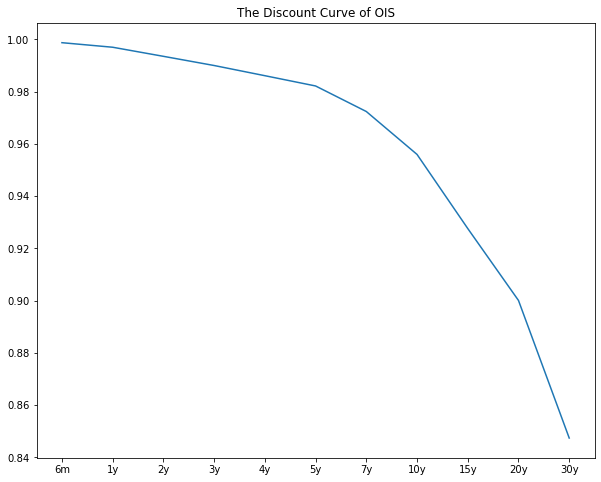

In [268]:
plt.figure(figsize=(10,8))
plt.plot(ois.index, ois.df)
plt.title("The Discount Curve of OIS")

### linear interporlate the discount factor of OIS

In [269]:
df =  pd.DataFrame({'Tenor' : np.linspace(1,30,30)},index= np.linspace(1,30,30))
df.loc[0.5,'Tenor'] = 0.5
df = df.sort_index()
o = ois[['df','Tenor']]
o.loc[:,'Tenor'] = o.loc[:,'Tenor']/360
o = o.set_index('Tenor')
df = df.join(o,on='Tenor',how='outer')
# linear interpolate
inter = df[df['df'].isna()].index
for i in inter:
    pos_1 = o.index[bisect.bisect_left(o.index,i)-1]
    pos_2 = o.index[bisect.bisect_left(o.index,i)]
    df.loc[i,'df'] = df.loc[pos_1,'df'] + (df.loc[pos_2,'df'] - df.loc[pos_1,'df'] ) * (i - pos_1)/(pos_2 - pos_1)
# concat data
Df = pd.DataFrame({'Tenor' : np.linspace(0.5,30,60)},index= np.linspace(0.5,30,60))
Df = Df.join(df['df'],how='outer')
inter = Df[Df['df'].isna()].index
for i in inter:
    Df.loc[i,'df'] = (Df.loc[i-0.5,'df'] + Df.loc[i+0.5,'df'])/2
Df['cumsum'] = Df.df.cumsum()
Df.tail()

<ipython-input-269-2ec0a7997d0f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  o.loc[:,'Tenor'] = o.loc[:,'Tenor']/360


,Tenor,df,cumsum
28.0,28.0,0.857941,52.159583
28.5,28.5,0.855307,53.014890
29.0,29.0,0.852674,53.867564
29.5,29.5,0.850040,54.717604
30.0,30.0,0.847407,55.565011


### Bootstrap the LIBOR discount factor 
Assume that the swap market is collateralized in cash and overnight interest is paid on collateral posted

In [270]:
irs = pd.read_excel('IR Data.xlsx','IRS').iloc[:,:3]
irs.index = irs['Tenor'].values
irs['Tenor'] = irs['Tenor'].apply(lambda x: re.findall("\d+", str(x))[0])
irs.loc['6m','Tenor'] = 0.5
irs['Tenor'] = irs['Tenor'].apply(lambda x: pd.to_numeric(x))
irs['Tenor'] = irs['Tenor'] * 360
irs.loc['6m','LIBOR'] = irs.loc['6m','Rate']
irs

,Tenor,Product,Rate,LIBOR
6m,180.0,LIBOR,0.0250,0.025
1y,360.0,IRS,0.0280,NaN
2y,720.0,IRS,0.0300,NaN
3y,1080.0,IRS,0.0315,NaN
4y,1440.0,IRS,0.0325,NaN
5y,1800.0,IRS,0.0330,NaN
7y,2520.0,IRS,0.0350,NaN
10y,3600.0,IRS,0.0370,NaN
15y,5400.0,IRS,0.0400,NaN
20y,7200.0,IRS,0.0450,NaN


In [271]:
irs.loc['6m', 'df'] = 1 / ( 1 + irs.loc['6m', 'Tenor'] / 360 * irs.loc['6m', 'LIBOR'])#D(0,6m)
# create a column of libor discount factor in Df 
Df.loc[0.5,'df_l'] = irs.loc['6m', 'df']
Df.loc[1.0,'df_l'] = Df.loc[0.5,'df_l']/(1+((irs.loc['1y', 'Rate'] * Df.loc[1,'cumsum'] - irs.loc['6m', 'LIBOR'] * Df.loc[0.5,'df'])*0.5 / Df.loc[1.0,'df']))

In [272]:
def IRS(x,start,end):
    string_1 = str(end) + 'y'
    string_0 = str(start) + 'y'
    term_list = []
    disounct_factor_list = [Df.loc[start,'df_l']]
    interval = int((end - (start+0.5))*2 + 1)
    for i in np.linspace(start+0.5,end,interval):
        disounct_factor_list.append((Df.loc[start,'df_l'] + ((i-start) * (x - Df.loc[start,'df_l'])/(end-start))))
        libor = ((disounct_factor_list[-2] / disounct_factor_list[-1]) -1)/0.5
        term_list.append(Df.loc[i,'df'] *  libor)
    return sum(term_list) - (irs.loc[string_1, 'Rate'] * Df.loc[end,'cumsum'] - irs.loc[string_0, 'Rate'] * Df.loc[start,'cumsum'])

In [273]:
start_list = [1,2,3,4,5,7,10,15,20]
end_list = [2,3,4,5,7,10,15,20,30]
for k in range(len(start_list)):
    start = start_list[k]
    end = end_list[k]
    interval = int((end - (start+0.5))*2 + 1)
    f = lambda x : IRS(x,start,end)
    a,b = 1e-12, 1
    Df.loc[end,'df_l'] = brentq(f, a, b)
    for i in np.linspace(start+0.5,end,interval):
        Df.loc[i,'df_l'] = Df.loc[start,'df_l'] + (i-start) *(Df.loc[end,'df_l'] -  Df.loc[start,'df_l'])/(end-start)

In [274]:
irs['df'] = Df[Df.Tenor.isin(irs.Tenor/360)]['df_l'].values
irs

,Tenor,Product,Rate,LIBOR,df
6m,180.0,LIBOR,0.0250,0.025,0.987654
1y,360.0,IRS,0.0280,NaN,0.972577
2y,720.0,IRS,0.0300,NaN,0.942179
3y,1080.0,IRS,0.0315,NaN,0.910482
4y,1440.0,IRS,0.0325,NaN,0.878981
5y,1800.0,IRS,0.0330,NaN,0.848989
7y,2520.0,IRS,0.0350,NaN,0.784216
10y,3600.0,IRS,0.0370,NaN,0.692710
15y,5400.0,IRS,0.0400,NaN,0.551081
20y,7200.0,IRS,0.0450,NaN,0.408218


Text(0.5, 1.0, 'The Discount Curve of Libor')

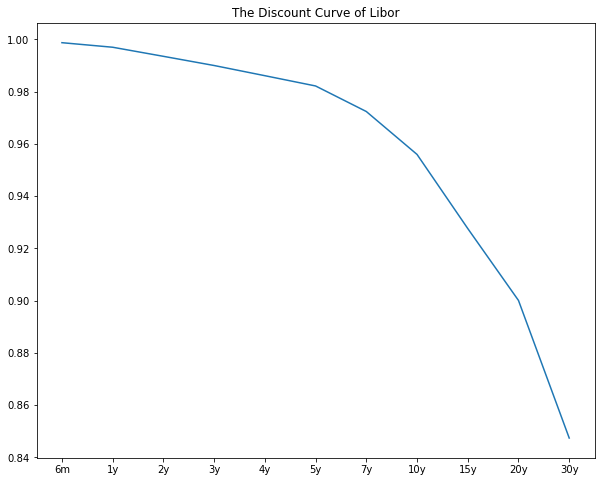

In [275]:
plt.figure(figsize=(10,8))
plt.plot(ois.index, ois.df)
plt.title("The Discount Curve of Libor")

### Foward swaption rate

In [276]:
Df.loc[0.5,'Libor'] = irs.loc['6m','LIBOR']
Df.loc[1:,'Libor'] = (Df.loc[:,'df_l'].shift().dropna()- Df.loc[1:,'df_l']) /  Df.loc[1:,'df_l']/0.5 # forward libor rate
Df.tail()

,Tenor,df,cumsum,df_l,Libor
28.0,28.0,0.857941,52.159583,0.260573,0.070827
28.5,28.5,0.855307,53.014890,0.251346,0.073427
29.0,29.0,0.852674,53.867564,0.242118,0.076225
29.5,29.5,0.850040,54.717604,0.232890,0.079246
30.0,30.0,0.847407,55.565011,0.223662,0.082515


In [277]:
tenor = [1,2,3,5,10]
expiry = [1,5,10]
fsr = pd.DataFrame(index=expiry,columns=tenor)
for i in expiry:
    for j in tenor:
        fsr.loc[i,j]=(Df.loc[(i+0.5):i+j,'df'] @ Df.loc[(i+0.5):i+j,'Libor']) / ( Df.loc[(i+0.5):i+j,'df'].sum())

In [278]:
fsr

,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


## Part 2 Calibrate the SABR model using swaption data

In [279]:
# import data
data = pd.read_excel('IR Data.xlsx','Swaption')[1:]
data.columns = data.iloc[0]
data = data[1:]
data['Expiry'] = data['Expiry'].apply(lambda x: re.findall("\d+", str(x))[0])
data['Tenor'] = data['Tenor'].apply(lambda x: re.findall("\d+", str(x))[0])
data = data.reset_index(drop=True)
data

1,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1,1,91.57,62.03,44.13,31.224,26.182,22.5,20.96,21.4,24.34,27.488,30.297
1,1,2,83.27,61.24,46.57,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1,3,73.92,56.87,44.77,35.745,32.317,29.78,28.29,27.8,28.77,30.725,32.833
3,1,5,55.19,44.64,36.51,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1,10,41.18,35.04,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5,1,67.8,49.09,38.4,31.485,29.06,27.26,26.04,25.32,24.94,25.32,25.98
6,5,2,57.88,46.41,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.54,26.76
7,5,3,53.43,44.44,38.18,33.437,31.536,29.98,28.76,27.82,26.67,26.2,26.15
8,5,5,41.99,36.524,32.326,29.005,27.677,26.6,25.73,25.02,24.06,23.57,23.4
9,5,10,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.49,22.25


In [280]:
# derive strike price from foward swaption rate
strike = pd.DataFrame(columns = data.columns[2:])
strike['ATM'] =  fsr.stack()
for i in data.columns[2:7]:
    strike[i] = strike['ATM'] - float(re.findall("\d+", str(i))[0])/10000
for i in data.columns[8:]:
    strike[i] = strike['ATM'] + float(re.findall("\d+", str(i))[0])/10000
strike

1       -200bps   -150bps   -100bps    -50bps    -25bps       ATM    +25bps  \
1  1   0.012007  0.017007  0.022007  0.027007  0.029507  0.032007  0.034507   
   2   0.013259  0.018259  0.023259  0.028259  0.030759  0.033259  0.035759   
   3   0.014011  0.019011  0.024011  0.029011  0.031511  0.034011  0.036511   
   5   0.015255  0.020255  0.025255  0.030255  0.032755  0.035255  0.037755   
   10  0.018428  0.023428  0.028428  0.033428  0.035928  0.038428  0.040928   
5  1   0.019274  0.024274  0.029274  0.034274  0.036774  0.039274  0.041774   
   2   0.020075  0.025075  0.030075  0.035075  0.037575  0.040075  0.042575   
   3   0.020072  0.025072  0.030072  0.035072  0.037572  0.040072  0.042572   
   5   0.021093  0.026093  0.031093  0.036093  0.038593  0.041093  0.043593   
   10  0.023634  0.028634  0.033634  0.038634  0.041134  0.043634  0.046134   
10 1   0.022189  0.027189  0.032189  0.037189  0.039689  0.042189  0.044689   
   2   0.023116  0.028116  0.033116  0.038116  0.040616  0.043116  0.045616   
   3   0.024097  0.029097  0.034097  0.039097  0.041597  0.044097  0.046597   
   5   0.026249  0.031249  0.036249  0.041249  0.043749  0.046249  0.048749   
   10  0.033458  0.038458  0.043458  0.048458  0.050958  0.053458  0.055958   

1        +50bps   +100bps   +150bps   +200bps  
1  1   0.037007  0.042007  0.047007  0.052007  
   2   0.038259  0.043259  0.048259  0.053259  
   3   0.039011  0.044011  0.049011  0.054011  
   5   0.040255  0.045255  0.050255  0.055255  
   10  0.043428  0.048428  0.053428  0.058428  
5  1   0.044274  0.049274  0.054274  0.059274  
   2   0.045075  0.050075  0.055075  0.060075  
   3   0.045072  0.050072  0.055072  0.060072  
   5   0.046093  0.051093  0.056093  0.061093  
   10  0.048634  0.053634  0.058634  0.063634  
10 1   0.047189  0.052189  0.057189  0.062189  
   2   0.048116  0.053116  0.058116  0.063116  
   3   0.049097  0.054097  0.059097  0.064097  
   5   0.051249  0.056249  0.061249  0.066249  
   10  0.058458  0.063458  0.068458  0.073458

In [281]:
# implied vol dataframe
ivol = pd.DataFrame(data.iloc[:,2:].values,index=strike.index,columns=strike.columns)
ivol=ivol.astype(float) /100
ivol

1      -200bps  -150bps  -100bps   -50bps   -25bps     ATM  +25bps  +50bps  \
1  1   0.91570  0.62030  0.44130  0.31224  0.26182  0.2250  0.2096  0.2140   
   2   0.83270  0.61240  0.46570  0.35807  0.31712  0.2872  0.2712  0.2684   
   3   0.73920  0.56870  0.44770  0.35745  0.32317  0.2978  0.2829  0.2780   
   5   0.55190  0.44640  0.36510  0.30242  0.27851  0.2607  0.2498  0.2456   
   10  0.41180  0.35040  0.30207  0.26619  0.25351  0.2447  0.2398  0.2382   
5  1   0.67800  0.49090  0.38400  0.31485  0.29060  0.2726  0.2604  0.2532   
   2   0.57880  0.46410  0.39033  0.33653  0.31531  0.2983  0.2856  0.2765   
   3   0.53430  0.44440  0.38180  0.33437  0.31536  0.2998  0.2876  0.2782   
   5   0.41990  0.36524  0.32326  0.29005  0.27677  0.2660  0.2573  0.2502   
   10  0.34417  0.30948  0.28148  0.25954  0.25136  0.2451  0.2399  0.2356   
10 1   0.55160  0.44320  0.37368  0.32259  0.30210  0.2854  0.2731  0.2645   
   2   0.51170  0.42900  0.37078  0.32622  0.30800  0.2928  0.2809  0.2720   
   3   0.48220  0.41430  0.36400  0.32439  0.30796  0.2940  0.2827  0.2738   
   5   0.40550  0.35891  0.32181  0.29144  0.27857  0.2674  0.2580  0.2502   
   10  0.33601  0.30509  0.27978  0.25926  0.25086  0.2437  0.2376  0.2324   

1      +100bps  +150bps  +200bps  
1  1    0.2434  0.27488  0.30297  
   2    0.2851  0.31025  0.33523  
   3    0.2877  0.30725  0.32833  
   5    0.2512  0.26536  0.28165  
   10   0.2425  0.25204  0.26355  
5  1    0.2494  0.25320  0.25980  
   2    0.2671  0.26540  0.26760  
   3    0.2667  0.26200  0.26150  
   5    0.2406  0.23570  0.23400  
   10   0.2291  0.22490  0.22250  
10 1    0.2561  0.25520  0.25780  
   2    0.2612  0.25720  0.25710  
   3    0.2618  0.25580  0.25370  
   5    0.2387  0.23170  0.22800  
   10   0.2244  0.21900  0.21560

### SABR Model

In [282]:
# sabr ivol
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

In [283]:
# calibration
def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err

In [284]:
# intial setting
beta = 0.9
initialGuess = [0.1,-0.5,0.5]

In [285]:
alpha_df = pd.DataFrame(index = fsr.index,columns=fsr.columns)
rho_df = pd.DataFrame(index = fsr.index,columns=fsr.columns)
nu_df = pd.DataFrame(index = fsr.index,columns=fsr.columns)

In [286]:
# calibrate via least_square
tenor = [1,2,3,5,10]
expiry = [1,5,10]
for i in expiry:
    for j in tenor:
        res = least_squares(lambda x: sabrcalibration(x,
                                              strike.loc[(i,j)],
                                              ivol.loc[(i,j)],
                                              strike.loc[(i,j)]['ATM'],
                                              i),
                    initialGuess)
        alpha_df.loc[i,j] = res.x[0]
        rho_df.loc[i,j] = res.x[1]
        nu_df.loc[i,j] = res.x[2]

### Calibrated Parameters

In [287]:
alpha_df  = alpha_df .apply(pd.to_numeric)
rho_df = rho_df.apply(pd.to_numeric)
nu_df = nu_df.apply(pd.to_numeric)

In [288]:
alpha_df 

,1,2,3,5,10
1,0.145627,0.190275,0.203528,0.186700,0.180907
5,0.163642,0.199080,0.211767,0.195223,0.179142
10,0.173564,0.190707,0.201525,0.196997,0.183186


In [289]:
rho_df

,1,2,3,5,10
1,-0.608602,-0.525103,-0.496427,-0.460836,-0.375598
5,-0.564995,-0.541080,-0.550737,-0.532711,-0.462350
10,-0.528920,-0.529032,-0.533967,-0.547261,-0.518840


In [290]:
nu_df

,1,2,3,5,10
1,1.932114,1.624413,1.376942,0.980118,0.648322
5,1.305494,1.052252,0.927520,0.652762,0.485244
10,0.987743,0.909688,0.853285,0.711470,0.568564


### Visulization

In [291]:
alpha = alpha_df.loc[1,1]
rho = rho_df.loc[1,1]
nu = nu_df.loc[1,1]
T = 1
F = fsr.loc[1,1]
K = strike.loc[(1,1)]
K.name = 'K'
K = K.to_frame()
market_vol = ivol.loc[(1,1)]
market_vol.name = 'market'
market_vol = market_vol.to_frame()
vol_df = pd.concat([K,market_vol],axis=1)
vol_df['SABR'] = vol_df['K'].apply(lambda k:SABR(F, k, T, alpha, beta, rho, nu))
vol_df

,K,market,SABR
1,,,
-200bps,0.012007,0.91570,0.832595
-150bps,0.017007,0.62030,0.637599
-100bps,0.022007,0.44130,0.480851
-50bps,0.027007,0.31224,0.343860
-25bps,0.029507,0.26182,0.280202
ATM,0.032007,0.22500,0.222695
+25bps,0.034507,0.20960,0.188877
+50bps,0.037007,0.21400,0.194468
+100bps,0.042007,0.24340,0.242067


Text(0.5, 1.0, 'Swaption Vol Calibration 1y x 1y')

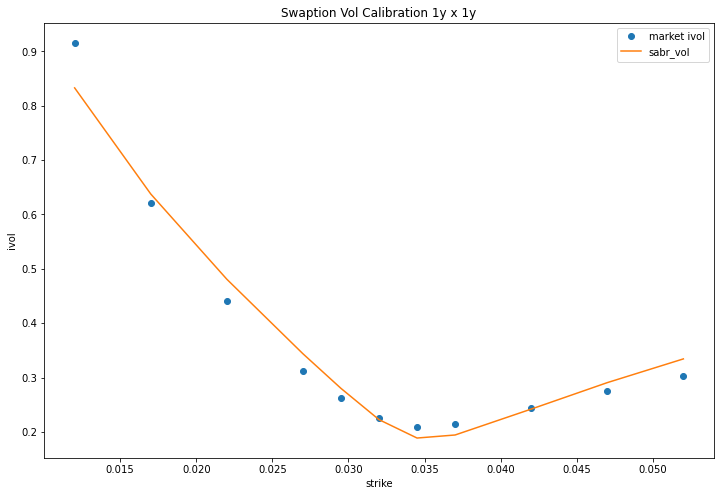

In [292]:
plt.figure(figsize=(12,8))
plt.plot(vol_df.K,vol_df.market,'o',label='market ivol')
plt.plot(vol_df.K,vol_df.SABR,label = 'sabr_vol')
plt.ylabel("ivol")
plt.xlabel("strike")
plt.legend()
plt.title('Swaption Vol Calibration 1y x 1y')

## Part 3 Convexity Correction

### IRR

In [293]:
def IRR_0(K, m, N):
    # implementation of IRR(K) function
    value = 1/K * ( 1.0 - 1/(1 + K/m)**(N*m) )
    return value

def IRR_1(K, m, N):
    # implementation of IRR'(K) function (1st derivative)
    firstDerivative = -1/K*IRR_0(K, m, N) + 1/(K*m)*N*m/(1+K/m)**(N*m+1)
    return firstDerivative

def IRR_2(K, m, N):
    # implementation of IRR''(K) function (2nd derivative)
    secondDerivative = -2/K*IRR_1(K, m, N) - 1/(K*m*m)*(N*m)*(N*m+1)/(1+K/m)**(N*m+2)
    return secondDerivative

### Static Replication

In [294]:
def g_0(K):
    return K

def g_1(K):
    return 1.0

def g_2(K):
    return 0.0

In [295]:
def h_0(K, m, N):
    # implementation of h(K)
    value = g_0(K) / IRR_0(K, m, N)
    return value

def h_1(K, m, N):
    # implementation of h'(K) (1st derivative)
    firstDerivative = (IRR_0(K, m, N)*g_1(K) - g_0(K)*IRR_1(K, m, N)) / IRR_0(K, m, N)**2
    return firstDerivative

def h_2(K, m, N):
    # implementation of h''(K) (2nd derivative)
    secondDerivative = ((IRR_0(K, m, N)*g_2(K) - IRR_2(K, m, N)*g_0(K) - 2.0*IRR_1(K, m, N)*g_1(K))/IRR_0(K, m, N)**2 
                        + 2.0*IRR_1(K, m, N)**2*g_0(K)/IRR_0(K, m, N)**3)
    return secondDerivative

In [296]:
# BS model to calculate option price
def cnorm(x):
    return (1.0 + math.erf(x / math.sqrt(2.0))) / 2.0

def black76CallPrice(F, vol, T, K):     
    stdev = vol * np.sqrt(T)
    d1 = np.log(F / K) / stdev + stdev / 2    
    d2 = d1 - stdev
    return  (F * cnorm(d1) - cnorm(d2) * K)

def black76PutPrice(F, vol, T, K):     
    stdev = vol * np.sqrt(T)
    d1 = np.log(F / K) / stdev + stdev / 2    
    d2 = d1 - stdev
    return  (K * cnorm(-d2) - cnorm(-d1) * F)

### CMS10y semi-annually 5y

In [297]:
# forward rate
F = pd.Series(index = np.linspace(0.5,5,10)) 
for i in np.linspace(0.5,5,10):
    F.loc[i] = (Df.loc[(i+0.5):i+10,'df'] @ Df.loc[(i+0.5): i+10,'Libor']) / (Df.loc[(i+0.5): i+10,'df'].sum())

<ipython-input-297-694dbc16a3be>:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  F = pd.Series(index = np.linspace(0.5,5,10))


In [298]:
# linear interpolate parameter of sabr
def param_interp(df):    
    df_d = df.reindex(np.arange(0,5.5, 0.5))
    df_d.iloc[0] = df.iloc[1] # flat
    df_d = df_d.interpolate()
    return df_d[0.5:]

alpha = param_interp(alpha_df.loc[10,:])
rho = param_interp(rho_df.loc[10,:])
nu = param_interp(nu_df.loc[10,:])

In [299]:
def CMS(F, m, N, Df, alpha,rho,nu,freq):
    fwd = F.loc[m]
    integrand_put = lambda K: h_2(K, freq, N) * IRR_0(fwd,freq,N) * black76PutPrice(fwd, SABR(fwd, K, m, alpha.loc[m], 0.9, rho.loc[m], nu.loc[m]), m, K)
    put_part = integrate.quad(integrand_put,0,fwd)[0]
    integrand_call = lambda K: h_2(K, freq, N) * IRR_0(fwd,freq,N) * black76CallPrice(fwd, SABR(fwd, K, m, alpha.loc[m], 0.9, rho.loc[m], nu.loc[m]), m, K)
    call_part = integrate.quad(integrand_call,fwd, fwd+0.02)[0] 
    return g_0(fwd) +  ( put_part + call_part)

In [300]:
pv = 0
for m in np.linspace(0.5,5,10):
    pv += Df.loc[m,'df'] * CMS(F, m, 10, Df, alpha,rho,nu,2) * 0.5
pv

0.20975356088457128

### Compare the forward swap rates with the CMS rate

In [301]:
fsr

,1,2,3,5,10
1,0.032007,0.033259,0.034011,0.035255,0.038428
5,0.039274,0.040075,0.040072,0.041093,0.043634
10,0.042189,0.043116,0.044097,0.046249,0.053458


In [302]:
tenor = [1,2,3,5,10]
expiry = [1,5,10]
cms = pd.DataFrame(index=expiry,columns=tenor)
for m in expiry:
    for N in tenor:
        cms.loc[m,N]=CMS(fsr.loc[:,N], m, N, Df, alpha_df.loc[:,N], rho_df.loc[:,N], nu_df.loc[:,N],2)
cms

,1,2,3,5,10
1,0.032089,0.033437,0.034257,0.035541,0.038947
5,0.039789,0.040943,0.041225,0.04256,0.046192
10,0.043066,0.044601,0.046198,0.04928,0.05962


In [303]:
convexity_correction= fsr - cms
convexity_correction

,1,2,3,5,10
1,-0.000082,-0.000178,-0.000246,-0.000286,-0.000519
5,-0.000515,-0.000868,-0.001153,-0.001467,-0.002559
10,-0.000877,-0.001486,-0.002101,-0.003031,-0.006162


## Part 4 Pricing Decomposition Option 

### Payoff1

A decompounded option pays the following at time $T = 5y$:

$$
Payoff: CMS 10y^{1/p} - 0.04^{1/q}
$$
where $p = 4$ and $q = 2$. 


In [304]:
def g_0(K):
    return K **(1/p) - 0.04 **(1/q)

def g_1(K):
    return (1/p)*K**(1/p -1)

def g_2(K):
    return (1/p -1)*(1/p)*K**(1/p-2)

In [305]:
F = (Df.loc[(5+0.5):5+10,'df'] @ Df.loc[(5+0.5): 5+10,'Libor']) / ( Df.loc[(5+0.5): 5+10,'df'].sum())
alpha = alpha_df.loc[5,10]
rho = rho_df.loc[5,10]
nu = nu_df.loc[5,10]

In [306]:
def static_replication1(F, m, N, Df, alpha,rho,nu,freq):
    fwd = F
    integrand_put = lambda K: h_2(K, freq, N) * IRR_0(fwd,freq,N) * black76PutPrice(fwd, SABR(fwd, K, m, alpha, 0.9, rho, nu), m, K)
    put_part = integrate.quad(integrand_put,1e-12,fwd)[0]
    integrand_call = lambda K: h_2(K, freq, N)* IRR_0(fwd,freq,N) * black76CallPrice(fwd, SABR(fwd, K, m, alpha, 0.9, rho, nu), m, K)
    call_part= integrate.quad(integrand_call,fwd, fwd+0.02)[0] # how to choose maxK?
    return g_0(fwd) +  (put_part + call_part)

In [307]:
p =4
q=2
pv = Df.loc[5,'df'] * static_replication1(F, 5, 10, Df, alpha,rho,nu,2)
print('PV of this payoff: ',pv)

PV of this payoff:  0.23033082881171263


<ipython-input-306-31d94c0772b8>:4: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  put_part = integrate.quad(integrand_put,1e-12,fwd)[0]


### Payoff2

$$
Payoff: (CMS 10y^{1/p} - 0.04^{1/q})^{+}
$$

In [308]:
def g_0(K):
    return max(K **(1/p) - 0.04 **(1/q),0)

def g_1(K):
    if (K **(1/p) )> (0.04 **(1/q)):
        return (1/p)*K**(1/p -1)
    else:
        return 0

def g_2(K):
    if K **(1/p) > 0.04 **(1/q):
        return (1/p -1)*(1/p)*K**(1/p-2)
    else:
        return 0

In [309]:
def static_replication2(F, m, N, Df, alpha,rho,nu,freq):
    fwd = F
    integrand_call = lambda K: h_2(K, freq, N)* IRR_0(fwd,freq,N) * black76CallPrice(fwd, SABR(fwd, K, m, alpha, 0.9, rho, nu), m, K)
    call_part= integrate.quad(integrand_call,fwd, fwd+0.02)[0] # how to choose maxK?
    return g_0(fwd) + g_1(fwd) * black76CallPrice(fwd, SABR(fwd, fwd, m, alpha, 0.9, rho, nu), m, fwd) + call_part

In [310]:
p =4
q=2
pv = Df.loc[5,'df'] * static_replication2(F, 5, 10, Df, alpha,rho,nu,2)
print('PV of this payoff: ',pv)

PV of this payoff:  0.2757505040176705
